In [2]:
import pandas as pd 
credentials = pd.read_csv('credentials.csv')
consumer_key = credentials['consumer_key'][0]
consumer_secret = credentials['consumer_secret'][0]
access_token = credentials['access_token'][0]
access_secret = credentials['access_secret'][0]
 
import tweepy
from tweepy import OAuthHandler
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
 
api = tweepy.API(auth, wait_on_rate_limit=True)

import warnings
warnings.simplefilter('ignore')

In [3]:
from pymongo import MongoClient
client = MongoClient()
news_tweets = client.tweets_db.new_tweets


In [4]:
news_tweets.count()

86726

In [5]:
import pandas as pd
tweets_df_all = pd.DataFrame([[tw['id'], tw['text'], tw['user']['screen_name']] 
                           for tw in news_tweets.find()], columns=['id', 'text', 'user'])


In [6]:
import numpy as np
np.unique(tweets_df_all.user).tolist()

[u'BBCTech',
 u'BNNBloomberg',
 u'CBCHealth',
 u'CBSHealth',
 u'ETEconomyNews',
 u'EverydayHealth',
 u'FOXSportsNews',
 u'FinancialTimes',
 u'ForbesTech',
 u'FoxNewsTech',
 u'HTSportsNews',
 u'HealthHive',
 u'KHNews',
 u'NBCNewsHealth',
 u'NBCNewsTech',
 u'NPRHealth',
 u'NewsdaySports',
 u'ReutersTech',
 u'SkyNewsWeather',
 u'SkySportsNews',
 u'TechCrunch',
 u'TheWeatherNetUS',
 u'bbchealth',
 u'bn9weather',
 u'breakingbytes',
 u'ftfinancenews',
 u'fttechnews',
 u'technology']

In [8]:
#del users_df['cat']

In [7]:
users_df = pd.DataFrame(np.unique(tweets_df_all.user).tolist(), columns=['user'])

In [8]:
users_df.shape

(28, 1)

In [9]:
cats = [('Business',  ['busi', 'econo', 'finan', 'BNNBloomberg', 'money', 'biz']),
        ('Traffic', None),
        ('Tech', ['tech', 'breakingbytes', 'CNET']),
        ('Heath', ['health', 'KHNews']),
        ('Sports', 'sport'),
        ('Weather', None),
        ('Ent', ['ent', 'art']),
        ('Politics', ['politic', 'rtetwip', 'realclear', 'PnPCBC']),
        
       ]
for cat in cats:
    keywords = cat[1]
    cat_name = cat[0]
    if keywords is None:
        keywords = cat_name
    if not isinstance(keywords, list):
        keywords = [keywords]
    print cat
    for index, u in zip(users_df.index, users_df.user):
        for kw in keywords:
            if u.lower().find(kw.lower()) != -1:
                print("\t%s %s"% (u, kw))
                users_df.loc[index, 'cat'] = cat_name
                break

('Business', ['busi', 'econo', 'finan', 'BNNBloomberg', 'money', 'biz'])
	BNNBloomberg BNNBloomberg
	ETEconomyNews econo
	FinancialTimes finan
	ftfinancenews finan
('Traffic', None)
('Tech', ['tech', 'breakingbytes', 'CNET'])
	BBCTech tech
	ForbesTech tech
	FoxNewsTech tech
	NBCNewsTech tech
	ReutersTech tech
	TechCrunch tech
	breakingbytes breakingbytes
	fttechnews tech
	technology tech
('Heath', ['health', 'KHNews'])
	CBCHealth health
	CBSHealth health
	EverydayHealth health
	HealthHive health
	KHNews KHNews
	NBCNewsHealth health
	NPRHealth health
	bbchealth health
('Sports', 'sport')
	FOXSportsNews sport
	HTSportsNews sport
	NewsdaySports sport
	SkySportsNews sport
('Weather', None)
	SkyNewsWeather Weather
	TheWeatherNetUS Weather
	bn9weather Weather
('Ent', ['ent', 'art'])
('Politics', ['politic', 'rtetwip', 'realclear', 'PnPCBC'])


In [10]:
users_df

,user,cat
0,BBCTech,Tech
1,BNNBloomberg,Business
2,CBCHealth,Heath
3,CBSHealth,Heath
4,ETEconomyNews,Business
5,EverydayHealth,Heath
6,FOXSportsNews,Sports
7,FinancialTimes,Business
8,ForbesTech,Tech
9,FoxNewsTech,Tech


In [13]:
users_df_fillna = users_df.fillna('Other')

In [15]:
#users = api.friends('@amnasri2', count=100)
#[u.screen_name for u in users]

In [14]:
users_df_fillna.set_index('user', inplace=True)

In [15]:
tweets_df_all['user'].head()

0    BNNBloomberg
1    BNNBloomberg
2    BNNBloomberg
3    BNNBloomberg
4    BNNBloomberg
Name: user, dtype: object

In [16]:
tweets_df_all['cat'] = tweets_df_all['user'].map(users_df_fillna['cat'])

In [17]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

In [18]:
remove_cats = ['Business', 'Ent']
keep_cats = [cat for cat in tweets_df_all.cat.unique() if cat not in remove_cats]


In [19]:
keep_cats = pd.DataFrame(keep_cats, columns=['cat'])

In [20]:
keep_cats

,cat
0,Weather
1,Sports
2,Heath
3,Tech


In [21]:
tweets_df = pd.merge(tweets_df_all, keep_cats, on=['cat'])

In [22]:
tweets_df['cat_encoded'] = label_encoder.fit_transform(tweets_df.cat)

In [31]:
tweets_df = tweets_df.sample(frac=1)
tweets_df.reset_index(inplace=True, drop=True)
tweets_df.head()

,index,id,text,user,cat,cat_encoded
0,59277,1009757146484011008,Lydia now supports Samsung Pay by @romaindille...,TechCrunch,Tech,2
1,18216,935389724168019968,RT @bmrwoods: Jelena Dokic pops in to discuss ...,FOXSportsNews,Sports,1
2,56763,904962495365963776,China bans initial coin offerings calling them...,BBCTech,Tech,2
3,6496,928231249621274624,RT @rkotinsky: Good Morning from Florida - @GM...,bn9weather,Weather,3
4,14617,992133657157566465,Jason Vargas’ second poor start dooms Mets as ...,NewsdaySports,Sports,1


In [33]:
import pandas as pd
#tweets_df.to_pickle('data/tweets_df.pkl')
tweets_df = pd.read_pickle('data/tweets_df.pkl')
tweets_df.reset_index(inplace=True, drop=True)
tweets_df.head()

In [81]:
from multiprocessing import Process

user_del_list =  [ u'CTVVancouver',
                  u'abcnews',
                  u'TIME',
                  u'TwitterNews',
u'NBCNews',
 u'BBCWorld'
 u'TIME',
 u'washingtonpost',
 u'news_welle',
 u'CBSNews',
]

#user_del_list = tweets_df[tweets_df['cat'] == 'Other']['user'].unique().tolist()

user_del_list =  [ u'BBCWorld',
                 'FortuneMagazine',
                 ]


In [82]:
from multiprocessing import Process, Pipe

def f(conn):
    client = MongoClient()
    news_tweets = client.tweets_db.new_tweets
    for user in user_del_list:
        conn.send([user])
        for id in tweets_df[tweets_df['user']==user]['id']:
            news_tweets.delete_one({'id':id})
    conn.close()

parent_conn, child_conn = Pipe()
p = Process(target=f, args=(child_conn,))
p.start()
#p.join()
    


In [145]:
p.join()

In [101]:
print parent_conn.recv()


[u'BBCWorld']


In [163]:
cursor = news_tweets.find().sort([('timestamp', -1)]).limit(20)


In [317]:
import time
def collect_tweets(users):
    curr_count = news_tweets.count()
    now = time.time()
    print("Started collecting tweets")
    for user in users:
        #tweets = api.user_timeline(screen_name = user.screen_name, count=200)
        try:
            tweets = tweepy.Cursor(api.user_timeline,screen_name=user.screen_name).items()
        except:
            continue
            
        for tw in tweets:

            if news_tweets.find_one({'id':tw.id}):
                break

            try:
                news_tweets.insert_one(tw._json)
            except DuplicateKeyError:
                break
                
    new_count = news_tweets.count()
    new_time = time.time() - now
    print("Collected %d tweets in %.2f seconds" % (new_count - curr_count, new_time))
    

In [318]:
import threading
import time


class MyThread(threading.Thread):
    def __init__(self, interval, task, args=[], kwargs={}):
        super(MyThread, self).__init__()
        self.stop_ = False
        self.interval = interval
        self.args = args
        self.kwargs = kwargs
        self.task = task
        self.start()
        
    def run(self):
        while not self.stop_:
            self.task(*self.args, **self.kwargs)
            time.sleep(self.interval)
            
    def stop(self):
        self.stop_ = True
        
mythread = MyThread(15 * 60, collect_tweets, [users])

Started collecting tweets


In [279]:
mythread.stop()

In [41]:
news_tweets.count()

176239

In [34]:
from scipy import sparse
from sklearn.base import BaseEstimator, TransformerMixin
import re
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

class Preprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        comments_clean = []
        for c in X:
            c = c.replace('\\\\', '\\')
            c = c.replace('\\n', ' ')
            #c = c.replace('\'', '')
            c = re.sub(r'[-_"]', '', c)
            c = re.sub(r'[*%&,?!;]', ' ', c)
            c = re.sub(r"(.)\1{2,}", '\g<1>', c)
            c = re.sub(r'\.(\s+|$)', ' ', c)
            c = re.sub(r'[^\x00-\x7F]+',' ', c)
            #c = re.sub(r'@[^ ]*', ' ', c)
            #c = re.sub(r'[0-9]+', ' ', c)
            c = re.sub(r'https?://[\w./]+', ' ', c)
            c = [wordnet_lemmatizer.lemmatize(wordnet_lemmatizer.lemmatize(w, pos='v')).lower() 
                          for w in c.split()]
            c = " ".join(w for w in c if len(w) > 2)
            #c = " ".join([w.lower() for w in c.split()])# if 3<=len(w)<=40])
            comments_clean.append(c)
        return comments_clean

prep = Preprocessor()

In [35]:
tweets_df['text_processed'] = prep.fit_transform(tweets_df['text'])

In [36]:
import pandas as pd
#tweets_df.to_pickle('data/tweets_df1.pkl')
tweets_df = pd.read_pickle('data/tweets_df1.pkl')
tweets_df.head()

In [37]:
tweets_df['user'].value_counts()

ForbesTech         3595
EverydayHealth     3420
TechCrunch         3385
ReutersTech        3297
HTSportsNews       3283
NBCNewsHealth      3273
FoxNewsTech        3271
SkySportsNews      3266
bn9weather         3256
TheWeatherNetUS    3247
technology         3237
SkyNewsWeather     3236
fttechnews         3233
NewsdaySports      3228
CBSHealth          3223
bbchealth          3223
BBCTech            3220
NPRHealth          3220
CBCHealth          3219
NBCNewsTech        3214
FOXSportsNews      3202
HealthHive         3200
breakingbytes      1725
KHNews                4
Name: user, dtype: int64

In [38]:
tweets_df['cat'].value_counts()

Tech       28177
Heath      22782
Sports     12979
Weather     9739
Name: cat, dtype: int64

In [48]:
"""

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)

stemmer = SnowballStemmer('english')
lemmatizer = WordNetLemmatizer()

def lemmatize_stemming(text, stem=True):
    result = lemmatizer.lemmatize(text, pos='v')
    if stem:
        result = stemmer.stem(result)
    return result
    
def preprocess(text):
    
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS \
            and len(token) > 3 and len(token) < 40 \
            and token.isalpha:
            result.append(lemmatize_stemming(token, stem=False))
    return " ".join(result)


from sklearn.datasets import fetch_20newsgroups

#dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))
documents = [preprocess(tw['text']) for tw in news_tweets.find()]
"""

'\n\nimport gensim\nfrom gensim.utils import simple_preprocess\nfrom gensim.parsing.preprocessing import STOPWORDS\nfrom nltk.stem import WordNetLemmatizer, SnowballStemmer\nfrom nltk.stem.porter import *\nimport numpy as np\nnp.random.seed(2018)\n\nstemmer = SnowballStemmer(\'english\')\nlemmatizer = WordNetLemmatizer()\n\ndef lemmatize_stemming(text, stem=True):\n    result = lemmatizer.lemmatize(text, pos=\'v\')\n    if stem:\n        result = stemmer.stem(result)\n    return result\n    \ndef preprocess(text):\n    \n    result = []\n    for token in gensim.utils.simple_preprocess(text):\n        if token not in gensim.parsing.preprocessing.STOPWORDS             and len(token) > 3 and len(token) < 40             and token.isalpha:\n            result.append(lemmatize_stemming(token, stem=False))\n    return " ".join(result)\n\n\nfrom sklearn.datasets import fetch_20newsgroups\n\n#dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=(\'headers\', \'footers\', \'quotes\'

In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from nltk.corpus import stopwords
from scipy.sparse import hstack
from sklearn.linear_model import LogisticRegression

tfidf_word_vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_df=0.5, max_features=None,
                             min_df=2, stop_words='english', token_pattern=u'((?u)\\b\\w\\w+\\b|[#@]\w+)',
                             use_idf=True)

tfidf_char_vectorizer = TfidfVectorizer(ngram_range=(1, 7), analyzer='char', max_df=0.5, max_features=None,
                             min_df=2, stop_words='english', token_pattern=u'((?u)\\b\\w\\w+\\b|[#@]\w+)',
                             use_idf=True)

tfidf_word = tfidf_word_vectorizer.fit_transform(tweets_df['text_processed'])
tfidf_char = tfidf_char_vectorizer.fit_transform(tweets_df['text_processed'])

tfidf_word_char = hstack([tfidf_word, tfidf_char])

lr = LogisticRegression()
lr.fit(tfidf_word_char, tweets_df['cat_encoded'])

In [57]:
lr = LogisticRegression()
lr.fit(tfidf_word_char, tweets_df['cat_encoded'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [54]:
from sklearn.model_selection import cross_val_score

cross_val_score(lr, tfidf_word_char, tweets_df['cat_encoded'], n_jobs=4)

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


array([0.93209145, 0.93079236, 0.93269843])

In [149]:
tfidf_word_char

<136720x283828 sparse matrix of type '<type 'numpy.float64'>'
	with 18309760 stored elements in COOrdinate format>

In [101]:
from sklearn.model_selection import cross_val_score

cross_val_score(lr, tfidf, tweets_df['cat_encoded'])

array([0.90593734, 0.90070875, 0.90364486])

In [55]:
tfidf_word_vectorizer

TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=0.5, max_features=None, min_df=2,
        ngram_range=(1, 3), norm=u'l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern=u'((?u)\\b\\w\\w+\\b|[#@]\\w+)', tokenizer=None,
        use_idf=True, vocabulary=None)

In [102]:
lr.score?

In [57]:
import numpy as np
np.logspace(-1, 3, 5)

array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])

In [60]:
from sklearn.model_selection import GridSearchCV
gs = GridSearchCV(lr, param_grid={'C': np.logspace(-1, 3, 5)}, return_train_score=True, n_jobs=3)
gs.fit(tfidf, tweets_df['cat_encoded'])

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'C': array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [61]:
gs.cv_results_

/usr/local/lib/python2.7/dist-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python2.7/dist-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python2.7/dist-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python2.7/dist-packages/sklearn/utils/deprecation.py:1

{'mean_fit_time': array([ 6.40758928,  9.18070865, 12.77666863, 23.00750232, 42.54301699]),
 'mean_score_time': array([0.02959299, 0.03314765, 0.03409076, 0.03519869, 0.03402336]),
 'mean_test_score': array([0.85358397, 0.91446021, 0.93543739, 0.93583967, 0.93421592]),
 'mean_train_score': array([0.87329578, 0.95117394, 0.99208967, 0.99712917, 0.99762288]),
 'param_C': masked_array(data=[0.1, 1.0, 10.0, 100.0, 1000.0],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.1}, {'C': 1.0}, {'C': 10.0}, {'C': 100.0}, {'C': 1000.0}],
 'rank_test_score': array([5, 4, 2, 1, 3], dtype=int32),
 'split0_test_score': array([0.85411181, 0.91583289, 0.93584343, 0.93551431, 0.93378094]),
 'split0_train_score': array([0.87321162, 0.95176863, 0.99202361, 0.99697182, 0.99761915]),
 'split1_test_score': array([0.85342198, 0.91470827, 0.93570755, 0.93605863, 0.93454458]),
 'split1_train_score': array([0.87282083, 0.95105708, 0.992

In [62]:
gs.best_score_

0.9358396723229959

In [63]:
gs.best_params_

{'C': 100.0}

In [214]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
cross_val_score(rf, tfidf, tweets_df['cat_encoded'], n_jobs=3)

array([0.86, 0.87, 0.87])

In [60]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    tfidf, tweets_df['cat_encoded'], test_size=0.33, random_state=42)

In [61]:
lr = LogisticRegression()

In [236]:
lr = gs.best_estimator_

In [62]:
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [63]:
y_pred = lr.predict(X_test)

In [64]:
(y_pred != y_test).mean()

0.09805399175495368

In [239]:
label_encoder.classes_

array(['Heath', 'Politics', 'Sports', 'Tech', 'Traffic', 'Weather'],
      dtype=object)

In [240]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred,
                                            target_names=label_encoder.classes_))

             precision    recall  f1-score   support

      Heath       0.91      0.92      0.92     11718
   Politics       0.93      0.92      0.92     10378
     Sports       0.96      0.94      0.95      7666
       Tech       0.89      0.91      0.90     11004
    Traffic       0.99      0.93      0.96      1056
    Weather       0.97      0.91      0.94      3296

avg / total       0.92      0.92      0.92     45118



In [178]:
np.unique(y_test)

array([0, 1, 2, 3, 4, 5, 6, 7])

In [241]:
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[10815   292    92   486     0    33]
 [  383  9550    84   356     0     5]
 [  142    97  7220   190     1    16]
 [  483   312   116 10053     3    37]
 [   15    15     7    29   984     6]
 [   75    42    20   145     2  3012]]
Normalized confusion matrix
[[9.23e-01 2.49e-02 7.85e-03 4.15e-02 0.00e+00 2.82e-03]
 [3.69e-02 9.20e-01 8.09e-03 3.43e-02 0.00e+00 4.82e-04]
 [1.85e-02 1.27e-02 9.42e-01 2.48e-02 1.30e-04 2.09e-03]
 [4.39e-02 2.84e-02 1.05e-02 9.14e-01 2.73e-04 3.36e-03]
 [1.42e-02 1.42e-02 6.63e-03 2.75e-02 9.32e-01 5.68e-03]
 [2.28e-02 1.27e-02 6.07e-03 4.40e-02 6.07e-04 9.14e-01]]


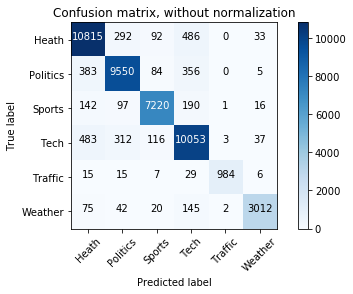

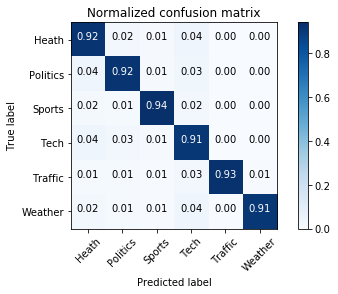

In [242]:
import itertools

# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

class_names = label_encoder.classes_

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')


# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()


## Pipeline

In [105]:
TfidfVectorizer?

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

word_vectorizer = TfidfVectorizer(stop_words='english', 
                                  token_pattern=u'((?u)\\b\\w\\w+\\b|[#@]\w+)')

char_vectorizer = TfidfVectorizer(analyzer='char', min_df=2, max_df=0.7)


In [7]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
vectorizer = FeatureUnion([('tfidf_word', word_vectorizer), ('tfidf_char', char_vectorizer)])
estimators = [('vectorizer', vectorizer), ('lr', lr)]
pl = Pipeline(estimators)

tweet_text = tweets_df['text_processed']
tweet_label = tweets_df['cat_encoded']


In [8]:
import numpy as np

In [ ]:
param_grid = {
    'vectorizer__tfidf_word__ngram_range': [(1, 1), (1, 2)],
    'vectorizer__tfidf_char__ngram_range': [(1, 2), (1, 3)],
    'vectorizer__tfidf_word__min_df': [1, 2, 5],
    'vectorizer__tfidf_word__use_idf': [False, True],
    'lr__C': np.logspace(-1, 3, 5),
}

In [12]:
from sklearn.model_selection import GridSearchCV

gs = GridSearchCV(pl, param_grid=param_grid, n_jobs=2, verbose=10)

In [13]:
#import sys
#sys.stdout = open("gridsearch.log","w")


In [ ]:
gs.fit(tweet_text, tweet_label)

In [ ]:
gs

In [50]:
gs.best_score_

0.9311585722644822

## XGboost

In [34]:
import xgboost as xgb

gbm = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05, n_jobs=4)
gbm.fit(X_train, y_train)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=300,
       n_jobs=4, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [35]:
y_pred = gbm.predict(X_test)

/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [37]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred,
                                            target_names=label_encoder.classes_))

             precision    recall  f1-score   support

      Heath       0.87      0.67      0.75     11736
   Politics       0.86      0.71      0.78     10329
     Sports       0.87      0.66      0.75      7634
       Tech       0.54      0.88      0.67     11071
    Traffic       0.99      0.81      0.89      1103
    Weather       0.95      0.75      0.84      3245

avg / total       0.79      0.74      0.75     45118



In [36]:
np.mean(y_pred == y_test)

0.7387960459240215

In [79]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    tfidf[:10000], tweets_df['cat_encoded'][:10000], test_size=0.33, random_state=42)


In [43]:
label_encoder.classes_

array(['Heath', 'Politics', 'Sports', 'Tech', 'Traffic', 'Weather'],
      dtype=object)

In [44]:
tweets_df.cat_encoded.unique()

array([3, 2, 0, 1, 5, 4])

In [45]:
len(label_encoder.classes_)

6

In [57]:
X_train.shape

(670, 10000)

In [67]:
tfidf

<136720x10000 sparse matrix of type '<type 'numpy.float64'>'
	with 1059030 stored elements in Compressed Sparse Row format>

In [72]:
a = hp.quniform('n_estimators', 200, 600, 1)

In [77]:
hp.quniform?

In [94]:
print("mean accuracy: %0.2f %%" % 100)


mean accuracy: 100.00 %


In [81]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import time
import xgboost

def score(params):
    num_round = int(params['n_estimators'])
    del params['n_estimators']
    dtrain = xgboost.DMatrix(X_train, label=y_train)
    dvalid = xgboost.DMatrix(X_val, label=y_val)
    watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
    gbm_model = xgboost.train(params, 
                              dtrain, 
                              num_round,
                              evals=watchlist,
                              verbose_eval=False)
    predictions = gbm_model.predict(dvalid, ntree_limit=gbm_model.best_iteration)
    error = (y_val != np.array(predictions)).mean()
    #print("mean accuracy: %0.2f %%" % (1-error) * 100)
    error_vec.append(error)
    return {'loss': error, 'status': STATUS_OK}


def optimize(evals, cores, trials, optimizer=tpe.suggest, random_state=0):
    space = {
        'num_class': len(label_encoder.classes_),
        'n_estimators': hp.quniform('n_estimators', 300, 700, 1),
        'eta': hp.quniform('eta', 0.025, 0.25, 0.025), 
        'max_depth':  hp.choice('max_depth', np.arange(5, 20, dtype=int)),
        'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
        'subsample': hp.quniform('subsample', 0.7, 1, 0.05),
        'gamma': hp.quniform('gamma', 0.5, 1, 0.05),
        'colsample_bytree': hp.quniform('colsample_bytree', 0.7, 1, 0.05),
        'alpha' :  hp.quniform('alpha', 0, 10, 1),
        'lambda': hp.quniform('lambda', 1, 2, 0.1),
        'nthread': cores,
        'objective': 'multi:softmax',
        'booster': 'gbtree',
        'seed': random_state
    }
    best = fmin(score, space, algo=tpe.suggest, max_evals=evals, trials = trials)
    return best
    

trials = Trials()
cores = 4
n= 1000
error_vec = []
start = time.time()
best_param = optimize(evals = n,
                      optimizer=tpe.suggest,
                      cores = cores,
                      trials = trials)
print("------------------------------------")
print("The best hyperparameters are: ", "\n")
print(best_param)
end = time.time()
print('Time elapsed to optimize {0} executions: {1}'.format(n,end - start))

ValueError: unsupported format character '\' (0x5c) at index 21

## Learning curves

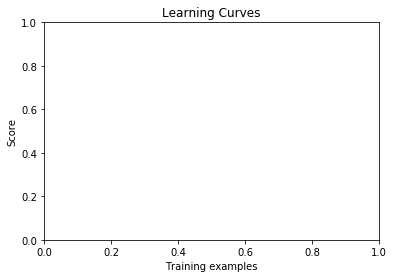

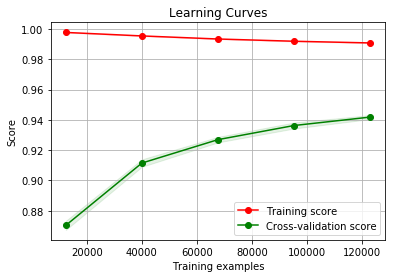

In [59]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, scoring=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, scoring=scoring, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


title = "Learning Curves"
# SVC is more expensive so we do a lower number of CV iterations:
#cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
#estimator = SVC(gamma=0.01)
#plot_learning_curve(estimator, title, X, y, (0.7, 1.01), cv=cv, n_jobs=4)
#estimator = LogisticRegression(C=1)
#estimator = gs.best_estimator_
#estimator = LogisticRegression(C=3, solver='newton-cg', max_iter=20)# class_weight = 'balanced')
estimator = LogisticRegression(C=10)
   
plot_learning_curve(estimator, title, tfidf, tweets_df['cat_encoded'], n_jobs=4, cv=10)


plt.show()

## One-vs-all Classification

In [39]:
tweets_df_sports = tweets_df.copy()

In [42]:
label_class_map = dict(set(zip(tweets_df['cat_encoded'], tweets_df['cat'])))
label_class_map

{0: 'Heath', 1: 'Sports', 2: 'Tech', 3: 'Weather'}

In [40]:
tweets_df.head()

,index,id,text,user,cat,cat_encoded,text_processed
0,59277,1009757146484011008,Lydia now supports Samsung Pay by @romaindille...,TechCrunch,Tech,2,lydia now support samsung pay @romaindillet
1,18216,935389724168019968,RT @bmrwoods: Jelena Dokic pops in to discuss ...,FOXSportsNews,Sports,1,@bmrwoods: jelena dokic pop discus reaction he...
2,56763,904962495365963776,China bans initial coin offerings calling them...,BBCTech,Tech,2,china ban initial coin offer call them 'illega...
3,6496,928231249621274624,RT @rkotinsky: Good Morning from Florida - @GM...,bn9weather,Weather,3,@rkotinsky: good morning from florida @gma @bn...
4,14617,992133657157566465,Jason Vargas’ second poor start dooms Mets as ...,NewsdaySports,Sports,1,jason vargas second poor start doom mets brave...


In [43]:
tweets_df_sports['sports'] = (tweets_df['cat_encoded'] == 3).astype(int)

In [44]:
tweets_df_sports

,index,id,text,user,cat,cat_encoded,text_processed,sports
0,59277,1009757146484011008,Lydia now supports Samsung Pay by @romaindille...,TechCrunch,Tech,2,lydia now support samsung pay @romaindillet,0
1,18216,935389724168019968,RT @bmrwoods: Jelena Dokic pops in to discuss ...,FOXSportsNews,Sports,1,@bmrwoods: jelena dokic pop discus reaction he...,0
2,56763,904962495365963776,China bans initial coin offerings calling them...,BBCTech,Tech,2,china ban initial coin offer call them 'illega...,0
3,6496,928231249621274624,RT @rkotinsky: Good Morning from Florida - @GM...,bn9weather,Weather,3,@rkotinsky: good morning from florida @gma @bn...,1
4,14617,992133657157566465,Jason Vargas’ second poor start dooms Mets as ...,NewsdaySports,Sports,1,jason vargas second poor start doom mets brave...,0
5,44499,152078454697885696,Memo: Gingrich praised Romney health plan - Ya...,HealthHive,Heath,0,memo: gingrich praise romney health plan yahoo...,0
6,52016,976854258783047680,UPDATE: S&amp;P 500 information technology ind...,ReutersTech,Tech,2,update: amp 500 information technology index d...,0
7,34313,872491622541344768,"If The Individual Insurance Market Crashes, Ca...",NPRHealth,Heath,0,the individual insurance market crashes can pe...,0
8,63816,995044289796177921,Boston Dynamics will start selling its dog-lik...,TechCrunch,Tech,2,boston dynamics will start sell doglike spotmi...,0
9,54735,950121865372229632,CES 2018: Can your saliva affect the way you s...,BBCTech,Tech,2,ces 2018: can your saliva affect the way you shop,0


In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from nltk.corpus import stopwords
from scipy.sparse import hstack
from sklearn.linear_model import LogisticRegression

tfidf_word_vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_df=0.5, max_features=None,
                             min_df=2, stop_words='english', token_pattern=u'((?u)\\b\\w\\w+\\b|[#@]\w+)',
                             use_idf=True)

tfidf_char_vectorizer = TfidfVectorizer(ngram_range=(1, 7), analyzer='char', max_df=0.5, max_features=None,
                             min_df=2, stop_words='english', token_pattern=u'((?u)\\b\\w\\w+\\b|[#@]\w+)',
                             use_idf=True)

tfidf_word = tfidf_word_vectorizer.fit_transform(tweets_df_sports['text_processed'])
tfidf_char = tfidf_char_vectorizer.fit_transform(tweets_df_sports['text_processed'])

tfidf_word_char = hstack([tfidf_word, tfidf_char])

lr = LogisticRegression()
lr.fit(tfidf_word_char, tweets_df_sports['sports'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [95]:
from pymongo import MongoClient
import json
from tweepy import Stream
from tweepy.streaming import StreamListener
import numpy as np

class MyListener(StreamListener):
 
    def on_data(self, data):
        global cnt
        try:
            tweet = json.loads(data)
            tweet_list.append(tweet)
            
            #tweets_collection.insert_one(tweet)
            if 'extended_tweet' in tweet:
                text = tweet['extended_tweet']['full_text']
            else:
                text = tweet['text']
                
            text_processed = prep.fit_transform([text])
            #if len(text_processed[0].split()) < 10:
            #    return True
            tfidf_word = tfidf_word_vectorizer.transform(text_processed)
            tfidf_char = tfidf_char_vectorizer.transform(text_processed)

            tfidf_word_char = hstack([tfidf_word, tfidf_char])

            y_pred = lr.predict(tfidf_word_char)
            y_pred_proba = lr.predict_proba(tfidf_word_char)
            if y_pred_proba[0][1] < 0.9:
                return True
            
            coordinates = None
            try:
                coordinates = tweet['place']['bounding_box'][u'coordinates']
            except KeyError:
                pass
            print(text, tweet['user']['screen_name'], y_pred[0], y_pred_proba[0][1], coordinates)
            cnt += 1
            if cnt % 1000 == 0:
                print(cnt)
            if cnt == max_count:
                twitter_stream.disconnect()
                print("done!")

        except BaseException as e:
            #print("Error on_data: %s" % str(e))
            pass
        return True
 
    def on_error(self, status):
        print(status)
        return True

#client = MongoClient()
#tweets_collection = client.tweets_db.tweets

cnt = 0
tweet_list = []
max_count = 10
twitter_stream = Stream(auth=auth, listener=MyListener())
GEOBOX_US_CANADA = [-128.755117, 26.415893, -52.437305, 54.093165]
twitter_stream.filter(locations=GEOBOX_US_CANADA, async=True)


(u'broken clouds -&gt; clear sky\ntemperature down 98\xb0F -&gt; 79\xb0F\nhumidity up 20% -&gt; 65%\nwind 24mph -&gt; 2mph', u'DrexelHeights', 1, 0.97377770311600853, [[[-111.097562, 32.09131], [-111.097562, 32.176145], [-111.006161, 32.176145], [-111.006161, 32.09131]]])
(u'current weather in Memphis: broken clouds, 83\xb0F\n74% humidity, wind 6mph, pressure 1021mb', u'_MemphisTN', 1, 0.95488262706283933, [[[-90.135782, 34.994192], [-90.135782, 35.272849], [-89.708276, 35.272849], [-89.708276, 34.994192]]])
(u'Wind 0.0 mph SSW. Barometer 30.06 in, Steady. Temperature 74.7 \xb0F. Rain today 0.25 in. Humidity 84%', u'AppaloosaGuy', 1, 0.95529328004259007, [[[-89.57151, 36.497129], [-89.57151, 39.147359], [-81.964971, 39.147359], [-81.964971, 36.497129]]])
(u'current weather in Bartlett: broken clouds, 83\xb0F\n74% humidity, wind 6mph, pressure 1021mb', u'BartlettTN', 1, 0.96993855418581165, [[[-89.887992, 35.186443], [-89.887992, 35.274531], [-89.741766, 35.274531], [-89.741766, 35.1864

In [92]:
tweet_list[0]['place']['bounding_box'][u'coordinates']

[[[-81.47749, 28.250764],
  [-81.47749, 28.347977],
  [-81.327204, 28.347977],
  [-81.327204, 28.250764]]]

In [94]:
twitter_stream.disconnect()


In [53]:
tweet_list[5]

u'#mothernaturerocks #sunsetyoga #yogaeverydamnday #gratefulandblessed @Hedges9Mile @ Hedges Nine Mile Point Restaura\u2026 https://t.co/P2LRu38Myb'

## Tweeter Streaming Prediction

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from nltk.corpus import stopwords
from scipy.sparse import hstack
from sklearn.linear_model import LogisticRegression

tfidf_word_vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_df=0.5, max_features=None,
                             min_df=2, stop_words='english', token_pattern=u'((?u)\\b\\w\\w+\\b|[#@]\w+)',
                             use_idf=True)

tfidf_char_vectorizer = TfidfVectorizer(ngram_range=(1, 7), analyzer='char', max_df=0.5, max_features=None,
                             min_df=2, stop_words='english', token_pattern=u'((?u)\\b\\w\\w+\\b|[#@]\w+)',
                             use_idf=True)

tfidf_word = tfidf_word_vectorizer.fit_transform(tweets_df['text_processed'])
tfidf_char = tfidf_char_vectorizer.fit_transform(tweets_df['text_processed'])

tfidf_word_char = hstack([tfidf_word, tfidf_char])

lr = LogisticRegression()
lr.fit(tfidf_word_char, tweets_df['cat_encoded'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [10]:
import numpy as np

In [16]:
label_class_map = dict(set(zip(tweets_df['cat_encoded'], tweets_df['cat'])))

In [29]:
label_encoder.classes_label_class_map = dict(set(zip(tweets_df['cat_encoded'], tweets_df['cat'])))

array(['Heath', 'Politics', 'Sports', 'Tech', 'Traffic', 'Weather'],
      dtype=object)

In [29]:
from pymongo import MongoClient
import json
from tweepy import Stream
from tweepy.streaming import StreamListener
import numpy as np

class MyListener(StreamListener):
 
    def on_data(self, data):
        global cnt
        #try:
        tweet = json.loads(data)
        #tweets_collection.insert_one(tweet)
        text = tweet['text']
        text_processed = prep.fit_transform([text])
        if len(text_processed[0].split()) < 10:
            return True
        
        tfidf_word = tfidf_word_vectorizer.transform(text_processed)
        tfidf_char = tfidf_char_vectorizer.transform(text_processed)

        tfidf_word_char = hstack([tfidf_word, tfidf_char])

        y_pred = lr.predict(tfidf_word_char)
        y_pred_proba = lr.predict_proba(tfidf_word_char)
        #if y_pred_proba.max() < 0.9:
        #    return True
        
        print(text, label_class_map[y_pred[0]], y_pred_proba)
        cnt += 1
        if cnt % 1000 == 0:
            print(cnt)
        if cnt == max_count:
            twitter_stream.disconnect()
            print("done!")

        #except BaseException as e:
        #    print("Error on_data: %s" % str(e))
        return True
 
    def on_error(self, status):
        print(status)
        return True

#client = MongoClient()
#tweets_collection = client.tweets_db.tweets

cnt = 0
max_count = 30
twitter_stream = Stream(auth=auth, listener=MyListener())
GEOBOX_US_CANADA = [-128.755117, 26.415893, -52.437305, 54.093165]
twitter_stream.filter(locations=GEOBOX_US_CANADA, async=True)


(u'If someome wants to shoot their shot at meeeee idk what you waiting for got right ahead', 'Sports', array([[0.15415068, 0.24505584, 0.45483231, 0.12380176, 0.0060415 ,
        0.01611792]]))
(u'@TheAnimatedBat @MrNoFollowers Some people just can\u2019t be happy. BATMAN: TAS is still one of my favs and I marathon\u2026 https://t.co/mJJLULhHTZ', 'Heath', array([[0.47137386, 0.10946085, 0.22715388, 0.14675124, 0.00657398,
        0.03868618]]))
(u'When we gone put a end to all this Satanic 666 goathead upside down cross bullshit \U0001f644\U0001f644\U0001f914', 'Tech', array([[0.2213677 , 0.1209102 , 0.27086112, 0.33332645, 0.01934757,
        0.03418697]]))
(u'@WendellSherk Self-imposed ignorance flows from the top when you have a, no interest in learning, leader at the top\u2026 https://t.co/gTGPGPAIzr', 'Heath', array([[0.36081422, 0.31194119, 0.08951875, 0.18512803, 0.01235433,
        0.04024349]]))
(u'If you want kids, have them.  If you don\u2019t want kids, don\u2019t have them

In [27]:
twitter_stream.disconnect()


9
